In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from urllib.request import urlretrieve

# Function to load dataset
def load_demand_dataset():
    dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00409/Daily_Demand_Forecasting_Orders.csv"
    local_filename = "Daily_Demand_Forecasting_Orders.csv"
    
    if not os.path.exists(local_filename):
        print("Downloading dataset...")
        urlretrieve(dataset_url, local_filename)
    
    # Load dataset
    df = pd.read_csv(local_filename, delimiter=';', decimal=',')
    print(f"Dataset loaded with shape: {df.shape}")
    return df

In [4]:
# Function to create sequences for LSTM
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length])
        y_seq.append(y[i + seq_length])
    return np.array(X_seq), np.array(y_seq)

# Load and preprocess dataset
df = load_demand_dataset()

# Feature scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df.iloc[:, :-1].values)  # Features
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(df.iloc[:, -1].values.reshape(-1, 1))  # Target

# Parameters
sequence_length = 7  # One week lookback period
train_size = int(len(X_scaled) * 0.8)

Dataset loaded with shape: (60, 13)


In [5]:
# Split data into train and test sets
X_train_data = X_scaled[:train_size]
X_test_data = X_scaled[train_size - sequence_length:]
y_train_data = y_scaled[:train_size]
y_test_data = y_scaled[train_size - sequence_length:]

# Create sequences
X_train, y_train = create_sequences(X_train_data, y_train_data, sequence_length)
X_test, y_test = create_sequences(X_test_data, y_test_data, sequence_length)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (41, 7, 12)
Testing data shape: (12, 7, 12)


In [6]:

# Function to build LSTM model
def build_lstm_model(sequence_length, n_features):
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(sequence_length, n_features), recurrent_dropout=0.1),
        LSTM(64, return_sequences=True, recurrent_dropout=0.1),
        LSTM(64, recurrent_dropout=0.1),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build model
model = build_lstm_model(sequence_length, X_train.shape[2])

# Early stopping and learning rate scheduler
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)


c:\Users\kanih\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 581ms/step - loss: 0.1839 - mae: 0.3771 - val_loss: 0.0747 - val_mae: 0.2304 - learning_rate: 0.0010
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0914 - mae: 0.2496 - val_loss: 0.0319 - val_mae: 0.1250 - learning_rate: 0.0010
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0525 - mae: 0.1604 - val_loss: 0.0218 - val_mae: 0.1400 - learning_rate: 0.0010
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0323 - mae: 0.1420 - val_loss: 0.0574 - val_mae: 0.1964 - learning_rate: 0.0010
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0473 - mae: 0.1916 - val_loss: 0.0528 - val_mae: 0.1871 - learning_rate: 0.0010
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0426 - mae: 0.1788 - val_loss: 0.0307 - val_mae: 0.1570 - learning_rate: 0.0010
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.0367 - mae: 0.1496 - val_loss: 0.0204 - val_mae: 0.1358 - learning_rate: 0.0010
Epoch 8/100
2/2 ━━━

In [8]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Invert predictions to original scale
train_predictions = y_scaler.inverse_transform(train_predictions)
y_train_inv = y_scaler.inverse_transform(y_train)
test_predictions = y_scaler.inverse_transform(test_predictions)
y_test_inv = y_scaler.inverse_transform(y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [9]:
# Function to calculate performance metrics
def calculate_metrics(actual, predicted):
    metrics = {
        'RMSE': math.sqrt(mean_squared_error(actual, predicted)),
        'MAE': mean_absolute_error(actual, predicted),
        'R²': r2_score(actual, predicted),
        'MAPE': np.mean(np.abs((actual - predicted) / (actual + 1e-10))) * 100
    }
    return metrics

# Calculate metrics
train_metrics = calculate_metrics(y_train_inv, train_predictions)
test_metrics = calculate_metrics(y_test_inv, test_predictions)

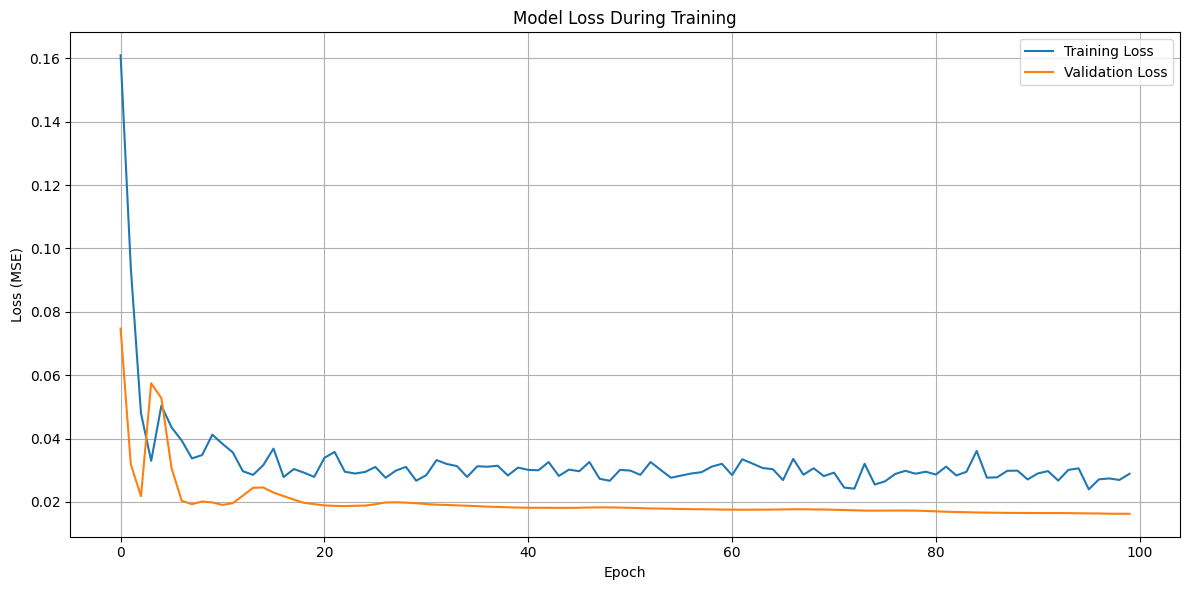

In [13]:
# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

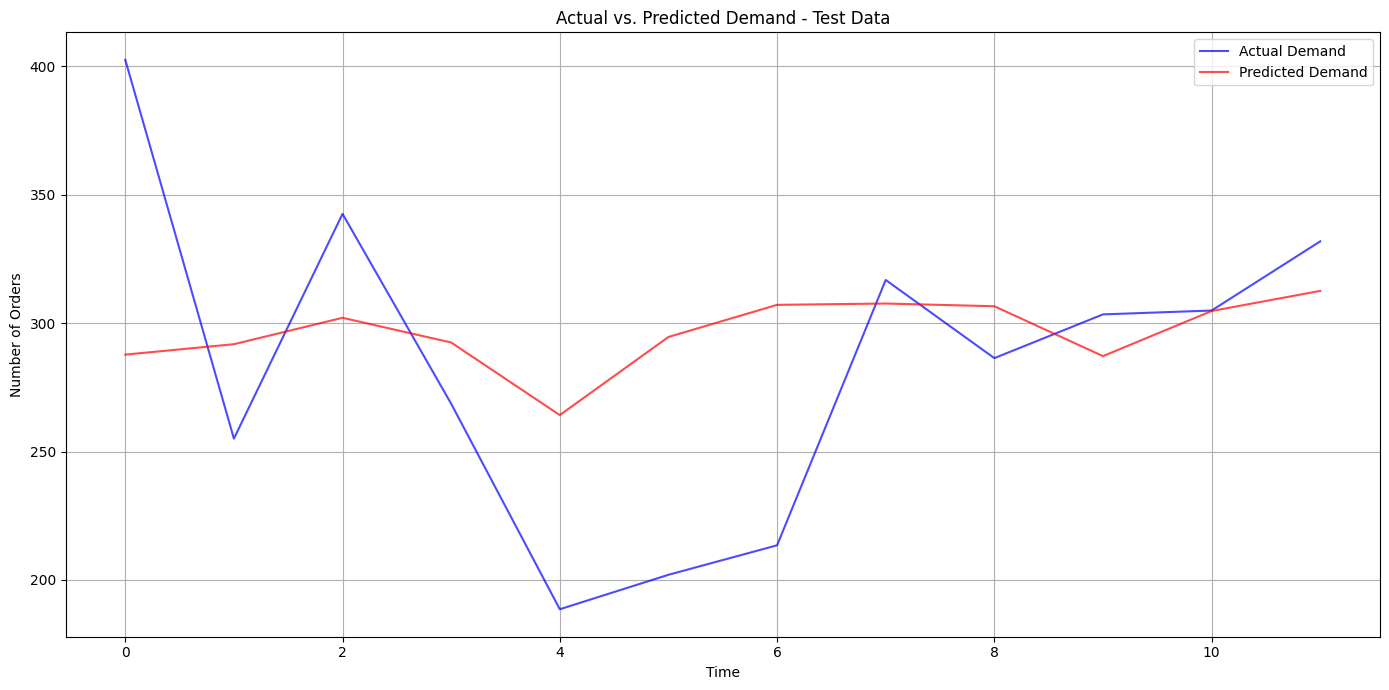

In [14]:
# Plot actual vs predicted for test data
plt.figure(figsize=(14, 7))
plt.plot(y_test_inv, label='Actual Demand', color='blue', alpha=0.7)
plt.plot(test_predictions, label='Predicted Demand', color='red', alpha=0.7)
plt.title('Actual vs. Predicted Demand - Test Data')
plt.ylabel('Number of Orders')
plt.xlabel('Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

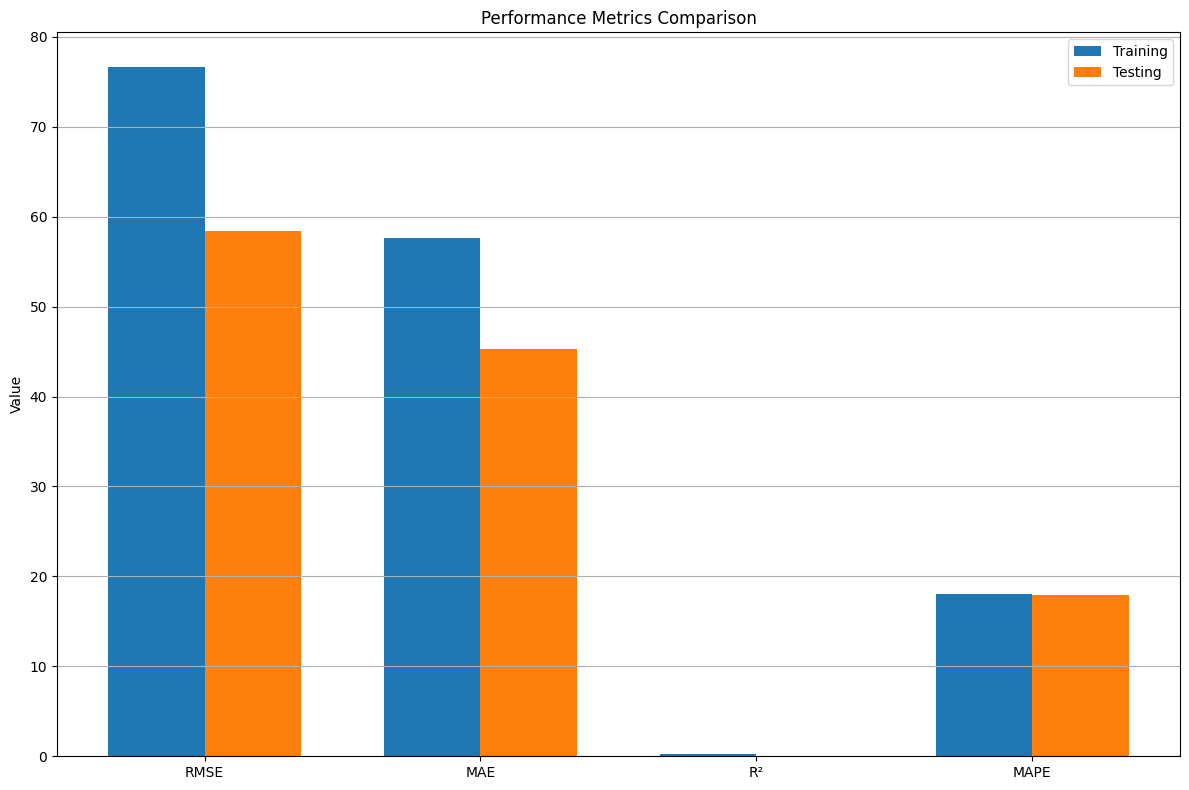

In [15]:

# Visualize performance metrics
metrics_names = list(train_metrics.keys())
train_values = [train_metrics[m] for m in metrics_names]
test_values = [test_metrics[m] for m in metrics_names]

plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_names))
width = 0.35
plt.bar(x - width/2, train_values, width, label='Training')
plt.bar(x + width/2, test_values, width, label='Testing')
plt.title('Performance Metrics Comparison')
plt.xticks(x, metrics_names)
plt.ylabel('Value')
plt.legend()
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()